<a href="https://colab.research.google.com/github/chayaphon/DADS7202_DL/blob/main/CNN_Sushi/VGG16_FineTune.ipynb\" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List all NVIDIA GPUs as avaialble.
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-299b49ee-76ac-3399-1e47-b9f202a90b71)


In [2]:
import sys
import numpy as np
import sklearn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]

NumPy 1.26.4

The scikit-learn version is 1.5.1
TensorFlow 2.10.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Set Seed

In [4]:
seed_value = 18928 #np.random.randint(1000, 99999)
print(seed_value)

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

18928


# Prep Data

In [5]:
x1 = np.load('./Images Numpy/x_sushi_aburi_224x224.npz')
x2 = np.load('./Images Numpy/x_sushi_ebi_224x224.npz')
x3 = np.load('./Images Numpy/x_sushi_maguro_224x224.npz')
x4 = np.load('./Images Numpy/x_sushi_salmon_224x224.npz')

x1 = x1['x']
x2 = x2['x']
x3 = x3['x']
x4 = x4['x']

y1 = np.array([0 for i in range(172)])
y2 = np.array([1 for i in range(172)])
y3 = np.array([2 for i in range(172)])
y4 = np.array([3 for i in range(172)])

print(f'x1 : {x1.shape} | y1: {y1.shape}')
print(f'x2 : {x2.shape} | y2: {y2.shape}')
print(f'x3 : {x3.shape} | y3: {y3.shape}')
print(f'x4 : {x4.shape} | y4: {y4.shape}')

x1 : (172, 224, 224, 3) | y1: (172,)
x2 : (172, 224, 224, 3) | y2: (172,)
x3 : (172, 224, 224, 3) | y3: (172,)
x4 : (172, 224, 224, 3) | y4: (172,)


In [6]:
x = np.concatenate((x1, x2, x3, x4))
y = np.concatenate((y1, y2, y3, y4))
print(x.shape)
print(y.shape)

(688, 224, 224, 3)
(688,)


# Train Test Split

In [7]:
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=np.random.randint(1,100), stratify=y)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(550, 224, 224, 3)
(550,)
(138, 224, 224, 3)
(138,)


# Visualize the first 10 image of x_train and x_test

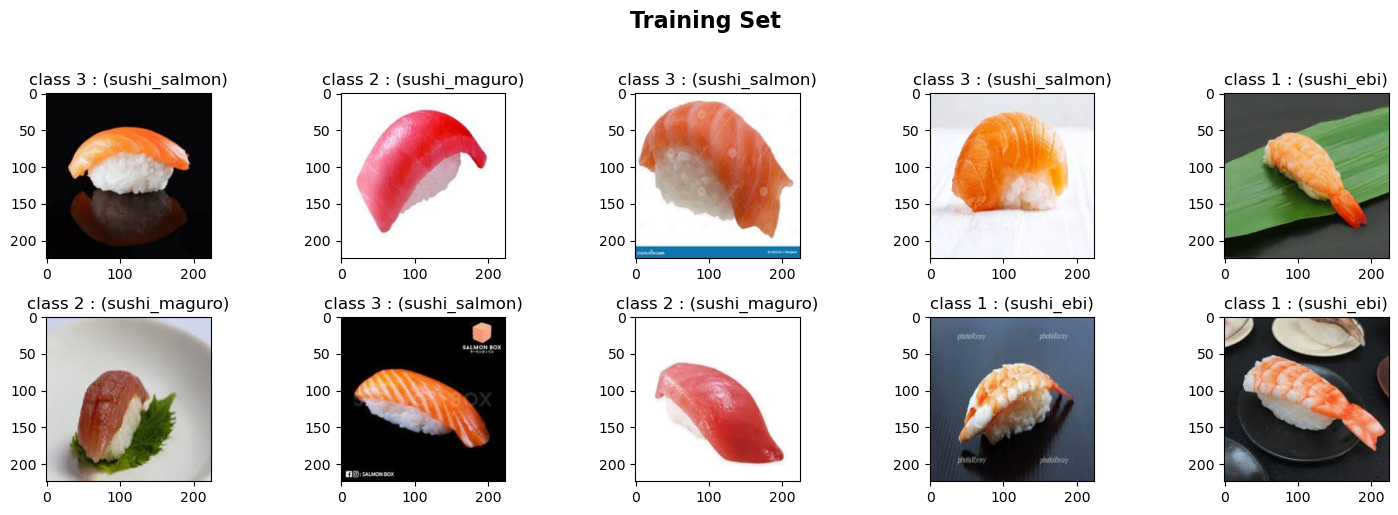

In [8]:
label = ['sushi_aburi','sushi_ebi','sushi_maguro','sushi_salmon']

plt.figure(figsize = (15,5))
plt.suptitle('Training Set', y=1.02, fontsize=16, weight='bold')
for i in range(10):
  plt.subplot(2, 5, i+1).set_title(f'class {y_train[i]} : ({label[y_train[i]]})')
  plt.imshow(x_train[i])
  
plt.tight_layout() 
plt.show()

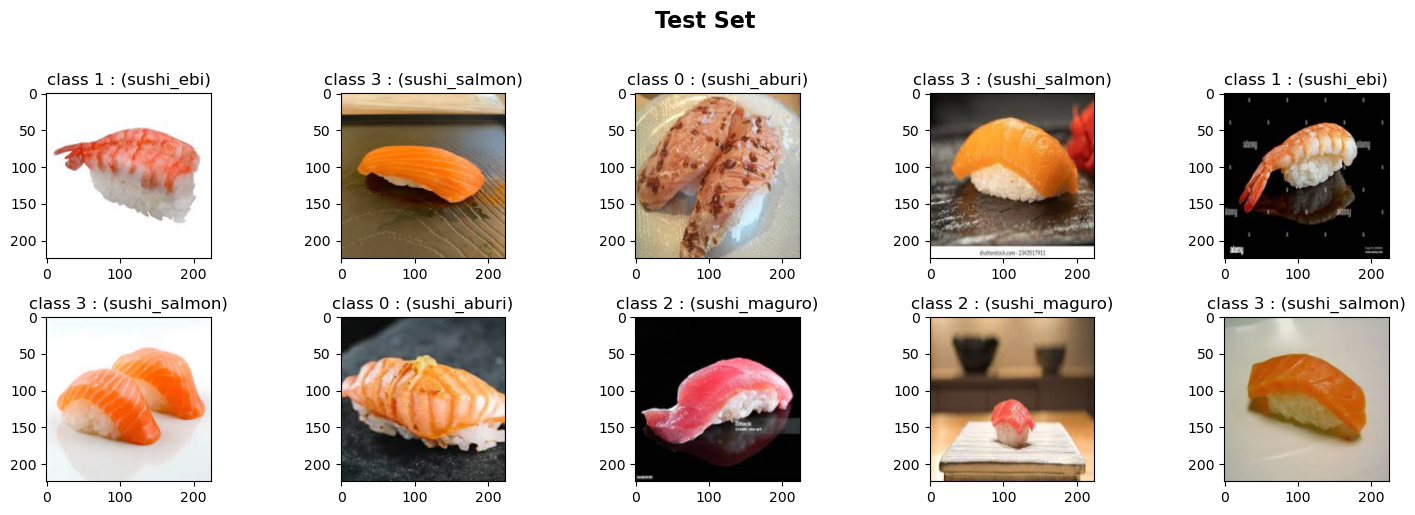

In [9]:
plt.figure(figsize = (15,5))
plt.suptitle('Test Set', y=1.02, fontsize=16, weight='bold')
for i in range(10):
  plt.subplot(2, 5, i+1).set_title(f'class {y_test[i]} : ({label[y_test[i]]})')
  plt.imshow(x_test[i])
  
plt.tight_layout()
plt.show()

# Select Pre-Trained Model VGG16

In [10]:
x_extractor = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

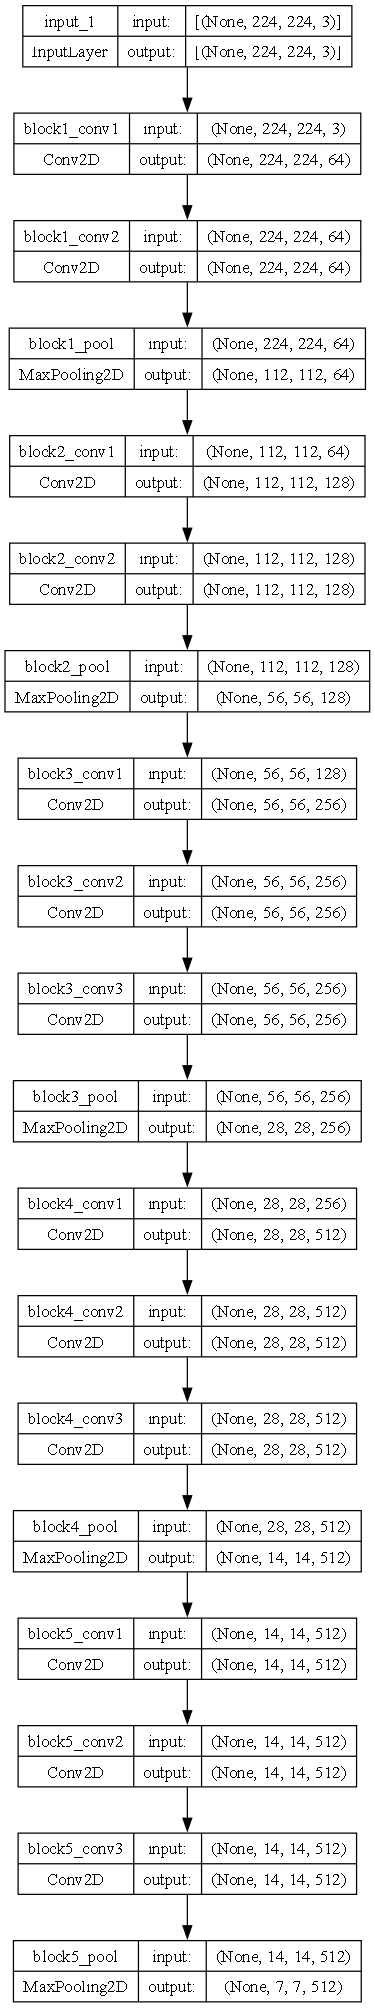

In [11]:
tf.keras.utils.plot_model(
    x_extractor, 
    to_file='./out/VGG16_Model.png', 
    show_shapes=True, 
    show_dtype=False, 
    show_layer_names=True, 
    dpi=90,
    rankdir='TB', 
    expand_nested=True 
)

# Recursively freeze all layers in the model

In [12]:
x_extractor.trainable = False
for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = False
Layer 18: Name = block5_pool, Trainable = False


# Un-freez some layer

In [13]:
#Access a layer by name
a = x_extractor.get_layer('block5_conv3')
#b = x_extractor.get_layer('block5_conv2')
# c = x_extractor.get_layer('block5_conv1')
# d = x_extractor.get_layer('block4_conv3')

a.trainable=True
#b.trainable=True
# c.trainable=True
# d.trainable=True

#print(f'Layer {a}: Name = {a.name}, Trainable = {a.trainable}')

for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = True
Layer 18: Name = block5_pool, Trainable = False


# Data Processing

In [14]:
x_train_vgg16 = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg16 = tf.keras.applications.vgg16.preprocess_input(x_test)

print(x_train_vgg16.shape)
print(x_test_vgg16.shape)

(550, 224, 224, 3)
(138, 224, 224, 3)


# Data Augmentation

In [15]:
def custom_augmentation(image):
    # Random crop
    #image = tf.image.random_crop(image, size=(100, 100, 3))  # Adjust size as needed
    # Add noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = image + noise
    # Adjust contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function        = custom_augmentation,
    #channel_shift_range           =0.1,
    #rescale                       = 1./255,         # Normalize pixel values
    samplewise_center             = True,           # Mean-center each image independently
    samplewise_std_normalization  = True,           # Normalize each image by its own standard deviation
    rotation_range              = 30,               # Rotation range ± x degrees
    height_shift_range          = 5.0,              # Vertical shift range ±0.15
    width_shift_range           = 4.0,              # Horizontal shift range ±0.15
    shear_range                 = 2.0,              # Shear range
    zoom_range                  = 0.2,              # Zoom range
    horizontal_flip             = True,             # Horizontal flip
    vertical_flip               = True,             # Vertical flip
    #fill_mode                   ='nearest',        # Fill mode for new pixels
    validation_split            = 0.2              # Split for validation
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rescale                       =1./255,
    samplewise_center             =True,
    samplewise_std_normalization  =True,
    )

# define seed to master seed
train_datagen.seed = seed_value
test_datagen.seed = seed_value

train_datagen.fit(x_train_vgg16)
test_datagen.fit(x_test_vgg16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39331073..4.629408].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7795826..1.5648704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54701567..3.2290342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1224265..2.5357625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.147029..0.50616103].


===== Train batch no. 1/1 =====


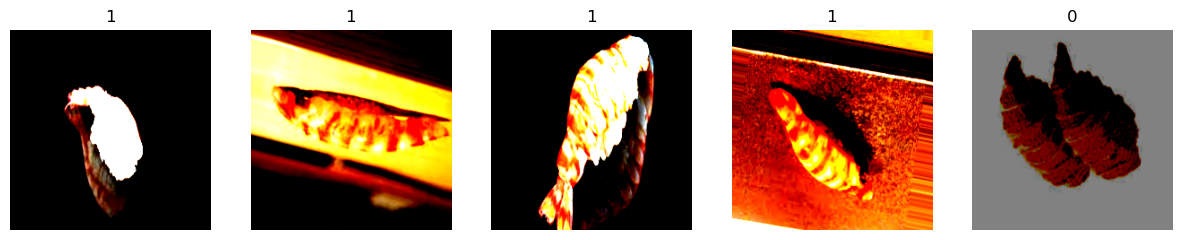

In [16]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=5, subset='training')
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(train_generator):
    print(f"===== Train batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9634535..1.3241048].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.537913..1.0295168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.2489066..2.9954937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1573915..0.5468357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2486374..2.8464348].


===== Validation batch no. 1/1 =====


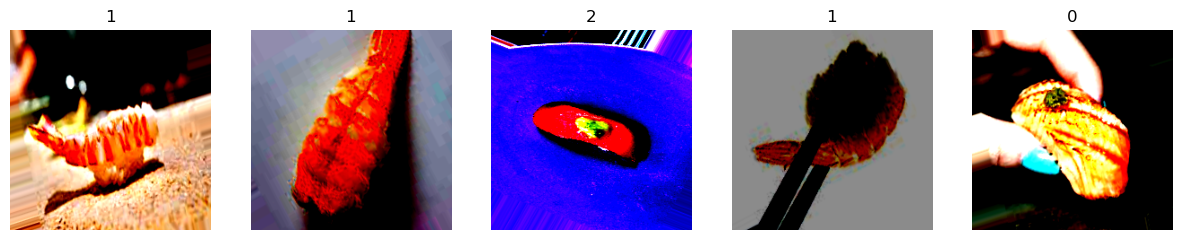

In [17]:
validation_generator = train_datagen.flow(x_train, y_train, batch_size=5, subset='validation')
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(validation_generator):
    print(f"===== Validation batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1561506..2.031244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1275496..0.45908603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.057107..1.8519176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2678868..3.840504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1139119..2.8309417].


===== Test batch no. 1/1 =====


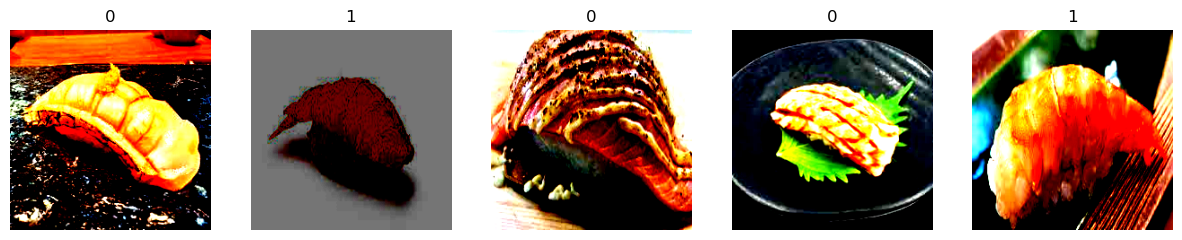

In [18]:
test_generator = test_datagen.flow(x_test, y_test, batch_size=5)
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(test_generator):
    print(f"===== Test batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

# Train Model

In [19]:
x = x_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
# x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = x_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005) , 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['acc'] 
            )

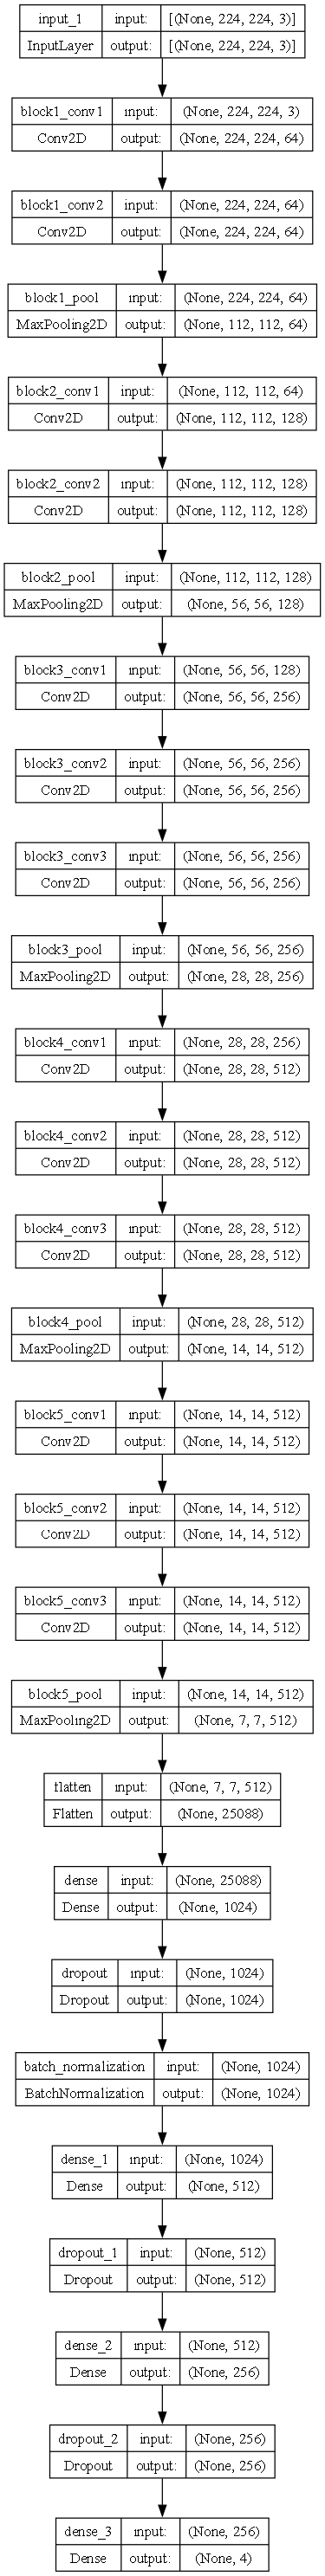

In [21]:
tf.keras.utils.plot_model(model, to_file = './out/VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 90)

# Fitting Model

In [22]:
t_batch_size = 32
v_batch_size = 48

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # monitor 'val_loss', 'val_acc'
    patience=8,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation performance
)

# Fit the model with early stopping
history = model.fit(
    train_datagen.flow(x_train_vgg16, y_train, batch_size=t_batch_size, subset='training'),
    epochs=50,
    verbose=2,
    validation_data=train_datagen.flow(x_train_vgg16, y_train, batch_size=v_batch_size, subset='validation'),
    callbacks=[early_stopping]  # Include early stopping callback
)

Epoch 1/50
14/14 - 26s - loss: 1.7777 - acc: 0.2909 - val_loss: 1.9422 - val_acc: 0.3273 - 26s/epoch - 2s/step
Epoch 2/50
14/14 - 5s - loss: 1.4363 - acc: 0.4227 - val_loss: 2.0790 - val_acc: 0.3091 - 5s/epoch - 325ms/step
Epoch 3/50
14/14 - 5s - loss: 1.1765 - acc: 0.4727 - val_loss: 1.2361 - val_acc: 0.5091 - 5s/epoch - 335ms/step
Epoch 4/50
14/14 - 5s - loss: 0.9731 - acc: 0.5818 - val_loss: 0.5254 - val_acc: 0.8364 - 5s/epoch - 337ms/step
Epoch 5/50
14/14 - 5s - loss: 0.6627 - acc: 0.7318 - val_loss: 0.3877 - val_acc: 0.9091 - 5s/epoch - 336ms/step
Epoch 6/50
14/14 - 5s - loss: 0.5707 - acc: 0.7818 - val_loss: 0.4033 - val_acc: 0.8727 - 5s/epoch - 324ms/step
Epoch 7/50
14/14 - 5s - loss: 0.4884 - acc: 0.8045 - val_loss: 0.3502 - val_acc: 0.8545 - 5s/epoch - 330ms/step
Epoch 8/50
14/14 - 5s - loss: 0.3626 - acc: 0.8727 - val_loss: 0.2619 - val_acc: 0.8818 - 5s/epoch - 327ms/step
Epoch 9/50
14/14 - 5s - loss: 0.3284 - acc: 0.8818 - val_loss: 0.2858 - val_acc: 0.9182 - 5s/epoch - 327m

In [23]:
results = model.evaluate(test_datagen.flow(x_test_vgg16, y_test, batch_size = 64))
print(f'{model.metrics_names}: {results}')

3/3 [==============================] - 12s 1s/step - loss: 0.2500 - acc: 0.9058
['loss', 'acc']: [0.25003781914711, 0.9057971239089966]


# Save Model

In [24]:
# save model
model.save('./save/VGG16_FineTune_model.h5')

# save weight
model.save_weights('./save/VGG16_FineTune_weight.h5')

# Summarize history of accuracy

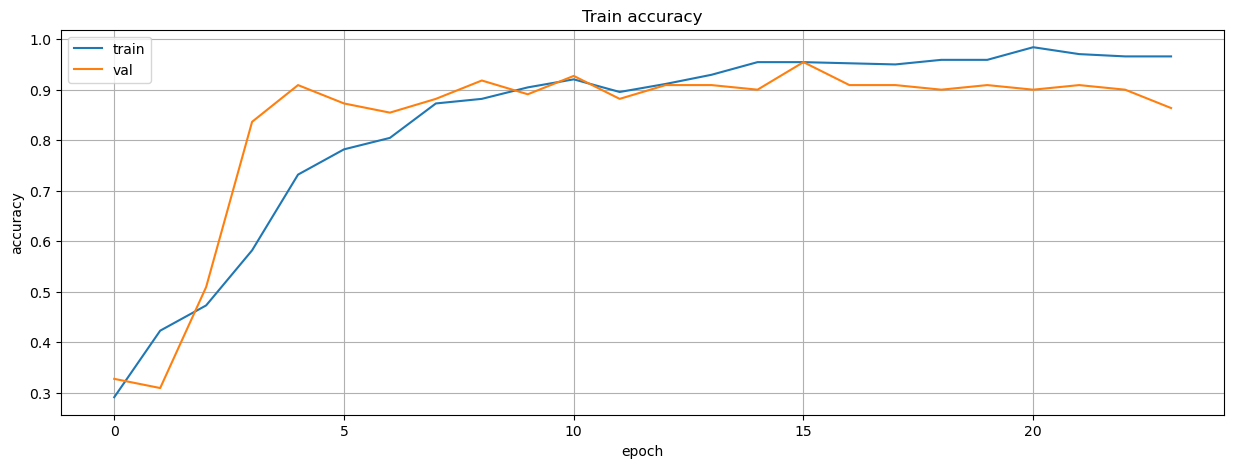

In [25]:
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

# Summarize history for loss

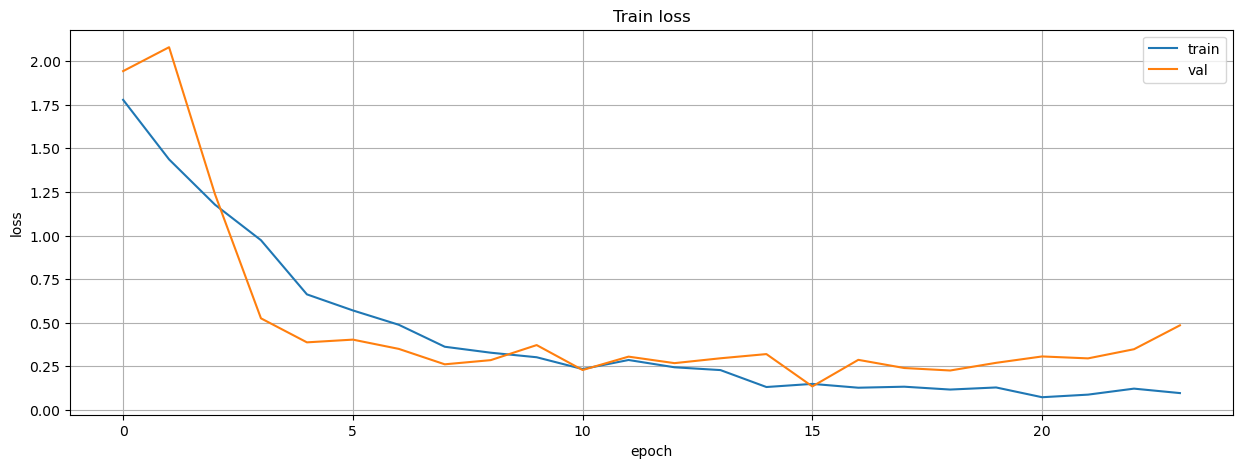

In [26]:
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

# Evaluate Model

1/1 [==============================] - 0s 24ms/step


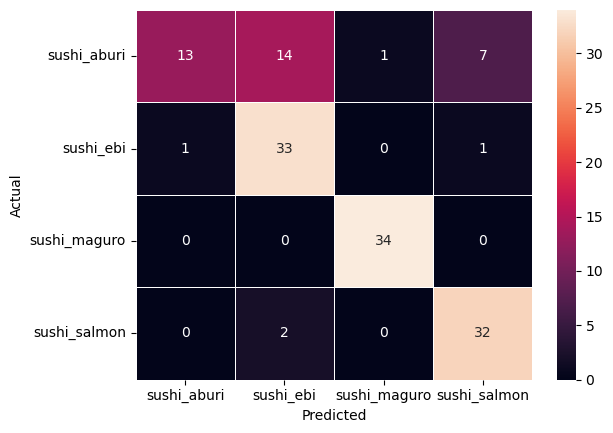

              precision    recall  f1-score   support

 sushi_aburi       0.93      0.37      0.53        35
   sushi_ebi       0.67      0.94      0.79        35
sushi_maguro       0.97      1.00      0.99        34
sushi_salmon       0.80      0.94      0.86        34

    accuracy                           0.81       138
   macro avg       0.84      0.81      0.79       138
weighted avg       0.84      0.81      0.79       138



In [27]:
# Get predictions for x_test_vgg16
y_pred = []
for i in range(len(x_test_vgg16)):
    x_input = x_test_vgg16[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=label)
print(report)

# Test Prediction

1/1 [==============================] - 0s 16ms/step


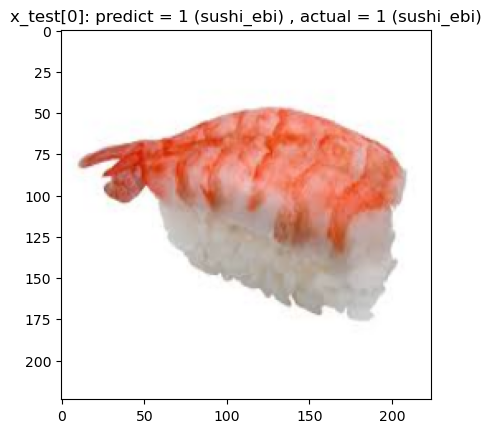

1/1 [==============================] - 0s 17ms/step


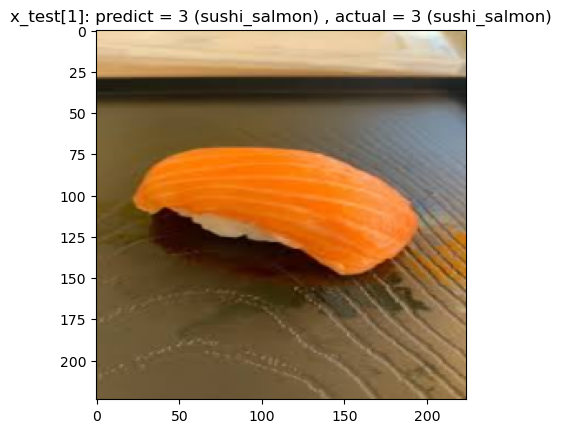

1/1 [==============================] - 0s 15ms/step


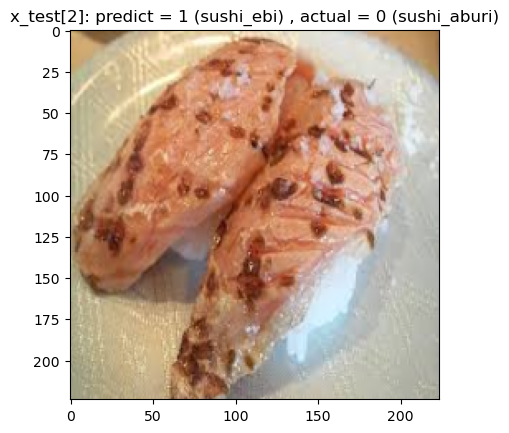

1/1 [==============================] - 0s 17ms/step


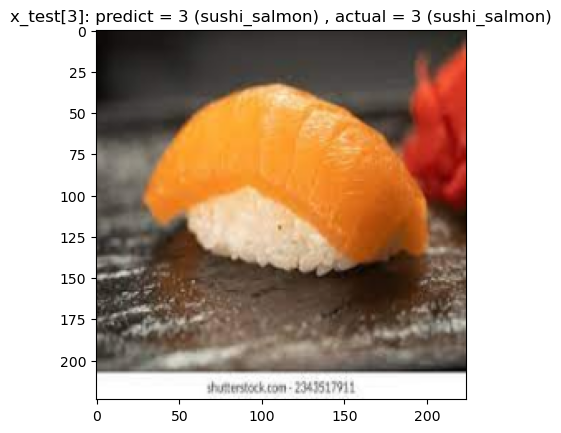

1/1 [==============================] - 0s 19ms/step


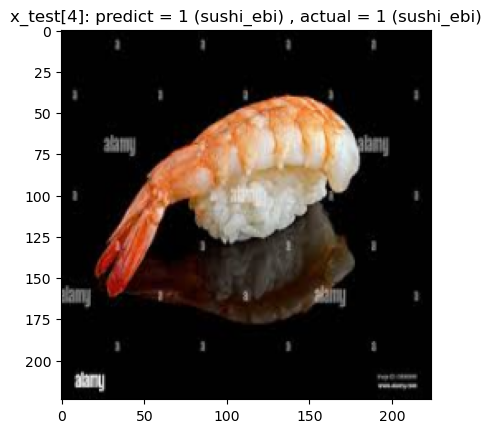

In [28]:
for i in range(5):
  y_pred = model.predict(x_test_vgg16[i].reshape(1,224,224,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# Grad-CAM

In [29]:
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

1/1 [==============================] - 0s 23ms/step
Predicted: sushi_ebi | Actual: sushi_ebi 


C:\Users\csorn\AppData\Local\Temp\ipykernel_20824\2170250685.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cmp.get_cmap("jet")


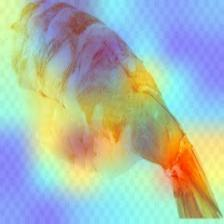

1/1 [==============================] - 0s 15ms/step
Predicted: sushi_maguro | Actual: sushi_maguro 


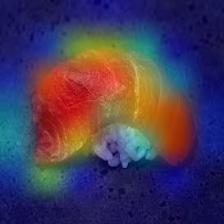

1/1 [==============================] - 0s 24ms/step
Predicted: sushi_ebi | Actual: sushi_ebi 


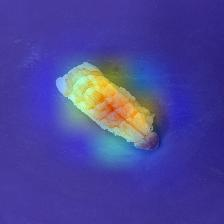

1/1 [==============================] - 0s 15ms/step
Predicted: sushi_ebi | Actual: sushi_ebi 


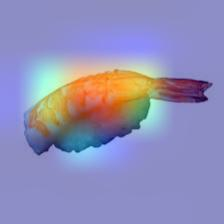

1/1 [==============================] - 0s 15ms/step
Predicted: sushi_ebi | Actual: sushi_aburi 


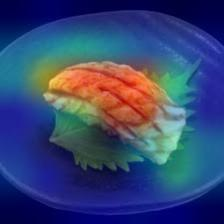

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="./out/cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c = np.random.randint(0,len(x_test)-1)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)